In [1]:
# Importacion de librerias
# Conexión a la base de datos
# ==========================================
import os
import sys
import pathlib


sys.path.append(
    os.path.join(pathlib.Path(os.getcwd()).parent)
)


from utils.bq_conn import bq_conn_file

bq_client = bq_conn_file(project_id="dsa-miad-365616")

# Tratamiento de datos
# ==========================================
import pandas as pd
import numpy as np
from datetime import datetime

# Graficas
# ==========================================
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import seaborn as sns

# Modelos ML
# ==========================================
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import nltk
import re
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Sequential, layers, preprocessing
from tensorflow.keras.layers import Dense, Dropout, Dropout, Embedding, Conv1D, GlobalMaxPool1D
import warnings
warnings.filterwarnings('ignore')

## Importo data

In [2]:
pd.options.display.max_columns = None

query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''
bq_client = bq_conn_file(project_id="dsa-miad-365616")
secop_I = bq_client.execute_query(query=query)
print(f"El número de filas del dataset: {secop_I.shape[0]}\nEl número de columnas del dataset: {secop_I.shape[1]}")
secop_I.head(5)

El número de filas del dataset: 26553
El número de columnas del dataset: 38


,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,departamento_ejecucion,numero_de_proceso,numero_de_contrato,cuantia_proceso,id_grupo,nombre_grupo,id_familia,nombre_familia,id_clase,nombre_clase,id_adjudicacion,tipo_identifi_del_contratista,identificacion_del_contratista,nom_razon_social_contratista,tipo_doc_representante_legal,identific_representante_legal,plazo_de_ejec_del_contrato_,dias_ejec_final_contrato,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,cundinamarca,CPMMSFFAMCNo01DE2019,CPMMSFFAMCNO01DE2019,50000000,E,productos de uso final,5022,productos de cereales legumbres,502213,harina productos de molinos,8143424,nit de persona juridica,900791326,inversiones ocazo,cedula de ciudadania,1022363447,330,330,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA184DE2019,184DE2019,22980096902,E,productos de uso final,5310,ropa,531027,uniformes,9226352,nit de persona juridica,860020227,fondo rotatorio de la policia forpo,nit de persona juridica,860020227,660,690,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA188DE2019,188DE2019,35998452,E,productos de uso final,5510,medios impresos,551015,publicaciones impresas,9265538,nit de persona juridica,830001113,imprenta nacional de colombia,nit de persona juridica,830001113,31,71,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA106DE2019,106DE2019,16767536,F,servicios,7210,servicios de mantenimiento reparaciones de con...,721015,servicios de apoyo para la construccion,8644918,nit de persona juridica,860025639,mitsubishi electric de colombia limitada,nit de persona juridica,860025639,170,170,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,bogota,CONVENIODEASOCIACIÓN231DE2018,231DE2018,0,F,servicios,7318,servicios de maquinado procesado,731810,servicios de maquinado,8059861,nit de persona juridica,806011019,recuperaciones naranjo recycling sas,cedula de ciudadania,57439563,360,360,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


In [3]:
secopI_filter = secop_I.filter(items=['detalle_del_objeto_a_contratar','prorrogado'])

# Contar las palabras en cada fila de la columna 'texto'
secopI_filter['conteo_palabras'] = secopI_filter['detalle_del_objeto_a_contratar'].apply(lambda x: len(x.split()))
secopI_filter.head(5)

,detalle_del_objeto_a_contratar,prorrogado,conteo_palabras
0,contratar servicio suministro elementos materi...,0,31
1,adquisicion uniformes para dotar personal cuer...,1,17
2,contratar diseno produccion tarjetas presentac...,1,32
3,prestar servicio mantenimiento preventivo corr...,0,20
4,desintegracion vehiculos automotores estado in...,0,11


In [4]:
secopI_filter['prorrogado']=secopI_filter['prorrogado'].astype(int)
secopI_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   detalle_del_objeto_a_contratar  26553 non-null  object
 1   prorrogado                      26553 non-null  int64 
 2   conteo_palabras                 26553 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 622.5+ KB


## Información de secuencias de palabras

In [5]:
print('Maximo de palabras es:', secopI_filter['conteo_palabras'].max())
print('Minimo de palabras es:', secopI_filter['conteo_palabras'].min())
print('Promedio de palabras es', secopI_filter['conteo_palabras'].mean())

Maximo de palabras es: 94
Minimo de palabras es: 1
Promedio de palabras es 14.86058072534177


## División de Train/Test

In [6]:
X = np.array(secopI_filter['detalle_del_objeto_a_contratar'])
y = np.array(secopI_filter['prorrogado'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=327)

print('Train set contains {} entries'.format(len(X_train)))
print("Test set contains {} entries".format(len(y_test)))

Train set contains 21242 entries
Test set contains 5311 entries


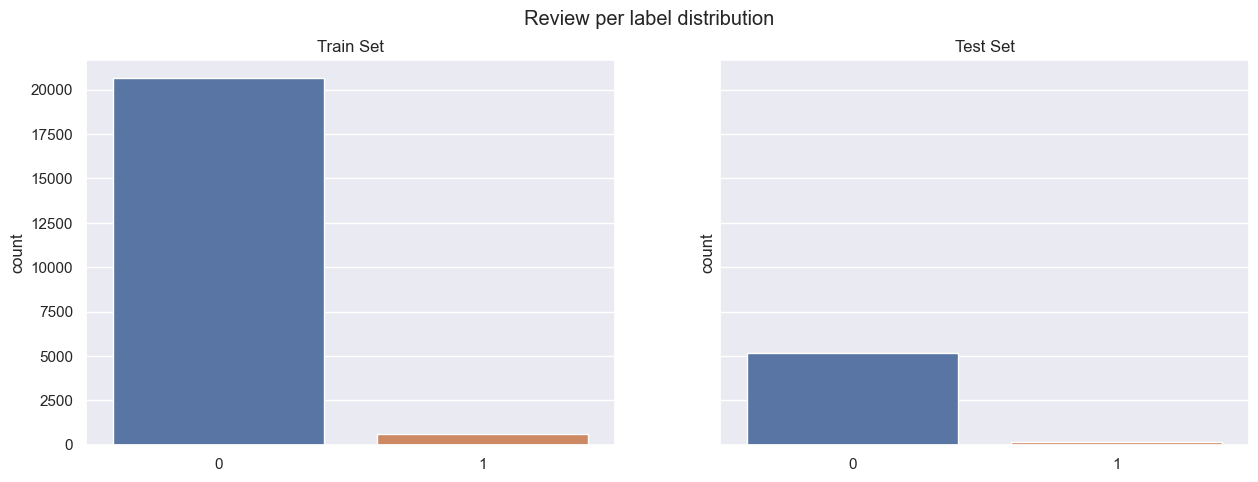

In [7]:
sns.set_theme(style="darkgrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Review per label distribution')
ax1 = sns.countplot(x=y_train, ax=ax1)
ax1.set_title('Train Set')
ax2 = sns.countplot(x=y_test, ax=ax2)
ax2.set_title('Test Set')
plt.show()

Estamos trabajando con un dataset desbalanceado

## Feature representation

In [8]:
num_words = 8000 # the numer of words to tokenize 
max_seq = 100 # maximum sequence size

# fit the tokenizer on trainig texts
tokenizer = preprocessing.text.Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

# Dictionary of words ordered in terms of their frequency 
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print(f" {vocab_size-1} unique tokens found")
print(list(word_index)[:10])

 7031 unique tokens found
['para', 'penitenciario', 'carcelario', 'establecimiento', 'contratar', 'seguridad', 'adquisicion', 'mediana', 'suministro', 'expendio']


## Padding

In [9]:
print("Original phrase:\n", X_train[0])
print()

# Turn the phrases into their numerical equivalents 
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
print('Phrase as sequence:', X_train_seq[0])
print()

# Padding of our sequences 
X_train_processed = preprocessing.sequence.pad_sequences(X_train_seq, padding='post', maxlen=max_seq)
X_test_processed = preprocessing.sequence.pad_sequences(X_test_seq, padding='post', maxlen=max_seq)
print('Padded sequence:', X_train_processed[0])

Original phrase:
 compra herramientas insumos demas elementos necesarios para confeccion atencion rehabilitacion recluso reclusion mujeres popayan inpec

Phrase as sequence: [15, 306, 41, 361, 11, 114, 1, 795, 33, 98, 113, 50, 52, 111, 13]

Padded sequence: [ 15 306  41 361  11 114   1 795  33  98 113  50  52 111  13   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


## Using pre-trained word embeddings

In [10]:
os.chdir('/Users/nataliajimenez/Downloads')
embedding_index = {}
with open("SBW-vectors-300-min5.txt") as f:
  for line in f:
    word, coef = line.split(maxsplit=1)
    coef = np.fromstring(coef, 'f', sep=' ')
    embedding_index[word] = coef 
print('{} embeddings found'.format(len(embedding_index)))

1000654 embeddings found


In [11]:
embedding_dim = 300
hits = 0 
misses = 0

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for w, i in word_index.items():
  embedding_vector = embedding_index.get(w)
  if embedding_vector is not None:
    hits+=1
    embedding_matrix[i] = embedding_vector
  else:
    misses += 1

print('{} words encoded with an embedding from SBW-vectors'.format(hits))
print('{} word embeddings not found'.format(misses))

5303 words encoded with an embedding from SBW-vectors
1728 word embeddings not found


## Initializing the model - LSTM
To adress the problem of binary classification we are going to compile a three-layer model organized as follows:

Embedding layer that takes the sequences and converts their elements into corresponding word vectors from the previously generated embedding matrix
LSTM layer
Dense layer

In [13]:
model = Sequential()

model.add(
    layers.Embedding(input_dim=vocab_size,
                     embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                     mask_zero=True,
                     output_dim=embedding_dim,  #embedding_dim, # dimension of dense embedding. 
                     input_length=max_seq)
)

# LSTM layer
model.add(layers.LSTM(128))
model.add(layers.Dropout(0.5))
# Dense output layer
model.add(layers.Dense(units=1, activation='sigmoid'))

# Model compilation 
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#Model recap
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          2109600   
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,329,377
Trainable params: 2,329,377
Non-trainable params: 0
_________________________________________________________________


## Training

In [14]:
es = EarlyStopping('loss', patience=2 , verbose=1)
history = model.fit(
    x=X_train_processed,
    y=y_train,
    callbacks=[es],
    epochs=15, 
    batch_size=128
)

Epoch 1/15


2023-05-06 01:12:19.774150: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


166/166 [==============================] - 41s 234ms/step - loss: 0.1406 - accuracy: 0.9702
Epoch 2/15
166/166 [==============================] - 38s 227ms/step - loss: 0.0921 - accuracy: 0.9734
Epoch 3/15
166/166 [==============================] - 38s 229ms/step - loss: 0.0788 - accuracy: 0.9760
Epoch 4/15
166/166 [==============================] - 38s 228ms/step - loss: 0.0701 - accuracy: 0.9772
Epoch 5/15
166/166 [==============================] - 38s 230ms/step - loss: 0.0632 - accuracy: 0.9794
Epoch 6/15
166/166 [==============================] - 38s 231ms/step - loss: 0.0586 - accuracy: 0.9804
Epoch 7/15
166/166 [==============================] - 39s 235ms/step - loss: 0.0541 - accuracy: 0.9823
Epoch 8/15
166/166 [==============================] - 42s 252ms/step - loss: 0.0495 - accuracy: 0.9824
Epoch 9/15
166/166 [==============================] - 42s 254ms/step - loss: 0.0460 - accuracy: 0.9837
Epoch 10/15
166/166 [==============================] - 55s 333ms/step - loss: 0.0448

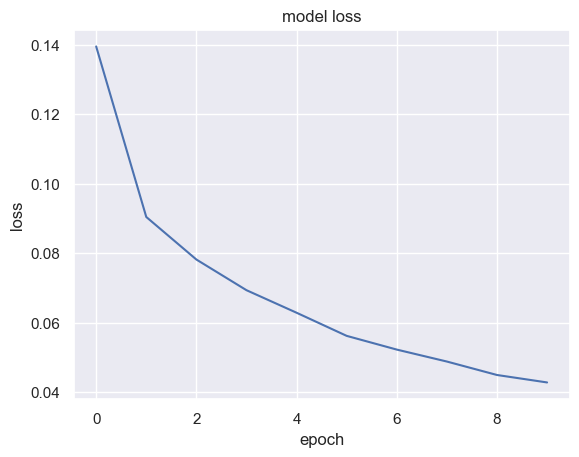

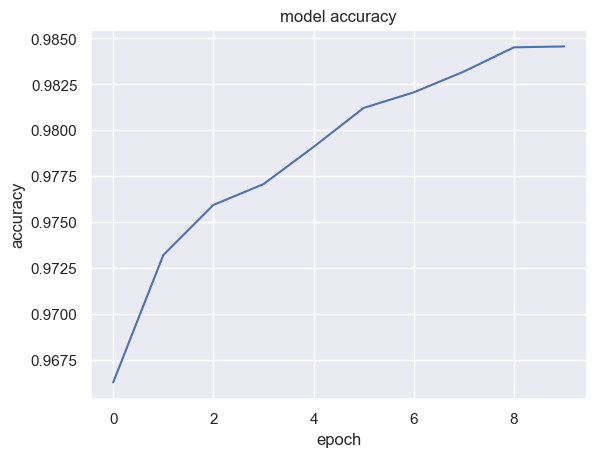

In [14]:
# Loss plot
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Accuracy plot
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

## Testing and Results

In [15]:
y_pred = model.predict(x=X_test_processed, batch_size=128)
y_pred = [0 if y < 0.2 else 1 for y in y_pred]

print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

42/42 [==============================] - 3s 66ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5176
           1       0.23      0.24      0.24       135

    accuracy                           0.96      5311
   macro avg       0.61      0.61      0.61      5311
weighted avg       0.96      0.96      0.96      5311

Accuracy: 0.9608360007531538


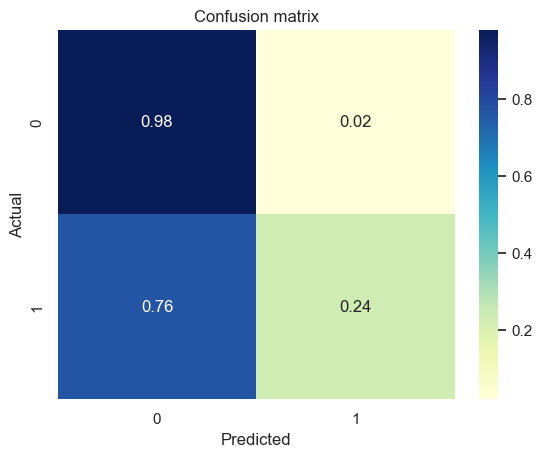

In [16]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()


## Model CNN

In [83]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_seq))
model.add(Conv1D(128, 3, activation='relu', padding="same"))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [84]:
# Model compilation 
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#Model recap
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          2109600   
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 256)          230656    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                      

In [85]:
es = EarlyStopping('loss', patience=2 , verbose=1)
history = model.fit(
    x=X_train_processed,
    y=y_train,
    callbacks=[es],
    epochs=10, 
    batch_size=128
)

Epoch 1/10
166/166 [==============================] - 23s 138ms/step - loss: 0.1442 - accuracy: 0.9667
Epoch 2/10
166/166 [==============================] - 23s 137ms/step - loss: 0.0907 - accuracy: 0.9727
Epoch 3/10
166/166 [==============================] - 22s 133ms/step - loss: 0.0732 - accuracy: 0.9743
Epoch 4/10
166/166 [==============================] - 22s 132ms/step - loss: 0.0628 - accuracy: 0.9771
Epoch 5/10
166/166 [==============================] - 21s 130ms/step - loss: 0.0535 - accuracy: 0.9805
Epoch 6/10
166/166 [==============================] - 16s 99ms/step - loss: 0.0479 - accuracy: 0.9824
Epoch 7/10
166/166 [==============================] - 15s 88ms/step - loss: 0.0405 - accuracy: 0.9852
Epoch 8/10
166/166 [==============================] - 13s 78ms/step - loss: 0.0368 - accuracy: 0.9863
Epoch 9/10
166/166 [==============================] - 18s 110ms/step - loss: 0.0308 - accuracy: 0.9874
Epoch 10/10
166/166 [==============================] - 23s 139ms/step - loss

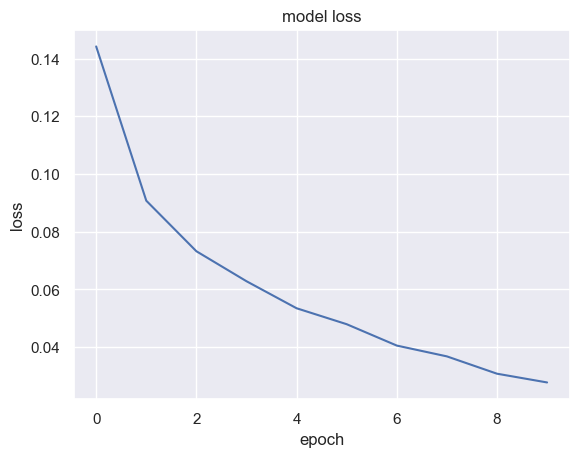

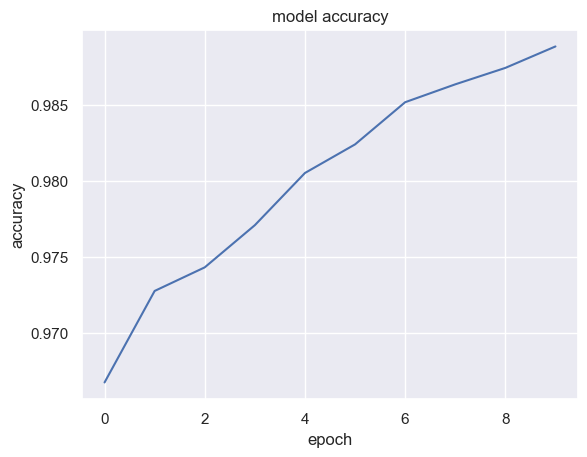

In [86]:
# Loss plot
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Accuracy plot
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

## Testing and Results

In [89]:
y_pred = model.predict(x=X_test_processed, batch_size=128)
y_pred = [0 if y < 0.4 else 1 for y in y_pred]

print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

42/42 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5176
           1       0.30      0.21      0.25       135

    accuracy                           0.97      5311
   macro avg       0.64      0.60      0.62      5311
weighted avg       0.96      0.97      0.96      5311

Accuracy: 0.9678026736961024


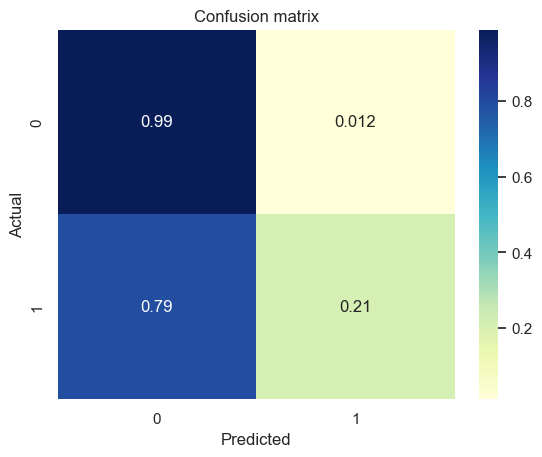

In [90]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()